# Understanding Hydrogen Absorption/Desorption in Metal-Organic Frameworks
## TA-3 Rimaz: Foundation for Stokes Flow + H2 Chemistry Modeling

**Date**: July 7, 2025  
**Author**: Rimaz Khan (TA-3)  
**Supervisor**: Prof. Domenico Lahaye  

---

## Objective

This notebook serves as the foundation for understanding:
1. **The physics** of hydrogen absorption/desorption in metal-organic frameworks (MOFs)
2. **The mathematical equations** governing the process 
3. **What results to expect** in our simulations
4. **How this connects** to the Stokes flow model we'll extend

This understanding will guide our development of the coupled Stokes flow + H2 chemistry model.

In [4]:
# Import required packages
using LinearAlgebra
using DifferentialEquations
using Plots
using StaticArrays

---

## Part 1: Physical Understanding

### What Are Metal-Organic Frameworks (MOFs)?

Think of MOFs as **tiny molecular sponges**:
- They have a porous structure with lots of empty space
- Hydrogen molecules can **stick to** (absorb into) the MOF material
- Later, hydrogen molecules can **release from** (desorb from) the MOF material
- This allows us to store hydrogen gas in a compact form

### The Two Key Processes

1. **Absorption (Storage)**: 
   - H₂ gas flows into the tank
   - H₂ molecules bind to the MOF material
   - Free H₂ gas density decreases, bound H₂ density increases
   - Process continues until MOF is saturated

2. **Desorption (Release)**:
   - H₂ molecules release from the MOF material
   - Free H₂ gas density increases, bound H₂ density decreases  
   - H₂ gas can flow out of the tank
   - Process continues until MOF is nearly empty

### Key Variables

- **ρₘ(x,y,t)**: Density of free H₂ gas (kg/m³) - can move with flow
- **ρₛ(x,y,t)**: Density of H₂ bound to solid MOF (kg/m³) - cannot move
- **ε**: Porosity (fraction of space that is void, typically ~0.7)
- **u(x,y,t)**: Flow velocity of H₂ gas (m/s)
- **p(x,y,t)**: Pressure of H₂ gas (Pa)

---

## Part 2: Mathematical Model

### The Core Equations (from Darzi-2016 paper)

**1. Evolution of Bound H₂ Density (Metal-Oxide Solid)**
$$
(1 - \epsilon) \frac{\partial \rho_s}{\partial t} = \dot{m}(\rho_s, t)
$$

**2. Evolution of Free H₂ Gas Density** 
$$
\epsilon \frac{\partial \rho_g}{\partial t} + \nabla \cdot (u \rho_g) = \nabla \cdot (D \nabla \rho_g) - \dot{m}(\rho_s, t)
$$

**IMPORTANT SIGN CONVENTION:**
The **negative sign** in the gas equation comes from the Darzi-2016 formulation. This means:
- **Absorption**: $\dot{m} > 0$ → $\rho_s$ increases, $\rho_g$ decreases (gas gets consumed)
- **Desorption**: $\dot{m} < 0$ → $\rho_s$ decreases, $\rho_g$ increases (gas gets released)

This represents **mass transfer** from gas phase to solid phase.

**3. Flow Equations (Stokes or Navier-Stokes)**
$$
\nabla \cdot u = 0 \quad \text{(Mass conservation)}
$$
$$
-\nabla p + \mu \nabla^2 u = f \quad \text{(Momentum conservation)}
$$

### The Reaction Rate $\dot{m}(\rho_s, t)$

This is the **heart of the chemistry** - it determines how fast H₂ absorbs/desorbs:

**For Absorption:**
$$
\dot{m}_a = C_a \exp\left(-\frac{E_a}{RT}\right) \log\left(\frac{p}{p_{eq,a}}\right) (\rho_{sat} - \rho_s)
$$

**For Desorption:**
$$
\dot{m}_d = C_d \exp\left(-\frac{E_d}{RT}\right) \frac{p - p_{eq,d}}{p_{eq,d}} (\rho_s - \rho_{emp})
$$

**Key Parameters:**
- **$\rho_{sat}$**: Maximum bound density (saturation)
- **$\rho_{emp}$**: Minimum bound density (empty)
- **$C_a, C_d$**: Reaction rate constants
- **$E_a, E_d$**: Activation energies
- **$p_{eq}$**: Equilibrium pressures

---

## Part 3: Simplified 0D Model (Well-Mixed Tank)

Before we tackle the full 2D problem, let's understand the basic behavior with a 0D model (no spatial variation, perfectly mixed tank).

In [6]:
# Define simplified reaction rates for demonstration
# (Real values would come from experiments or literature)

# Absorption: H2 gas gets absorbed into MOF
function reaction_rate_absorption(rho_s, params)
    rho_sat = params.rho_sat
    k_abs = params.k_abs
    
    # Rate proportional to available binding sites
    return k_abs * (rho_sat - rho_s)
end

# Desorption: H2 gas gets released from MOF  
function reaction_rate_desorption(rho_s, params)
    rho_emp = params.rho_emp
    k_des = params.k_des
    
    # Rate proportional to occupied binding sites
    return -k_des * (rho_s - rho_emp)
end

reaction_rate_desorption (generic function with 1 method)

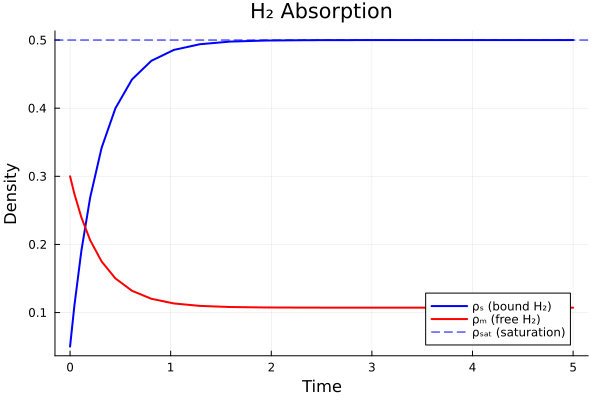

In [8]:
# 0D Model: Absorption Case
function absorption_ode!(du, u, params, t)
    rho_s, rho_g = u
    epsilon = params.epsilon
    
    # Reaction rate (positive for absorption)
    mdot = reaction_rate_absorption(rho_s, params)
    
    # Evolution equations (Darzi-2016 formulation)
    du[1] = mdot / (1 - epsilon)        # Bound H2 increases  
    du[2] = -mdot / epsilon             # Free H2 decreases (gets consumed)
end

# Parameters for absorption
params_abs = (
    rho_sat = 0.5,      # Maximum bound density
    rho_emp = 0.01,     # Minimum bound density  
    k_abs = 1.0,        # Absorption rate constant
    k_des = 0.5,        # Desorption rate constant
    epsilon = 0.7       # Porosity
)

# Initial conditions: little bound gas, lots of free gas  
u0_abs = [0.05, 0.3]  # [rho_s_initial, rho_g_initial]

# Time span
tspan = (0.0, 5.0)

# Solve absorption case
prob_abs = ODEProblem(absorption_ode!, u0_abs, tspan, params_abs)
sol_abs = solve(prob_abs)

# Plot results
p1 = plot(sol_abs.t, [u[1] for u in sol_abs.u], 
         label="ρₛ (bound H₂)", lw=2, color=:blue,
         xlabel="Time", ylabel="Density", title="H₂ Absorption")
plot!(p1, sol_abs.t, [u[2] for u in sol_abs.u], 
      label="ρₘ (free H₂)", lw=2, color=:red)
hline!(p1, [params_abs.rho_sat], label="ρₛₐₜ (saturation)", ls=:dash, color=:blue)

p1

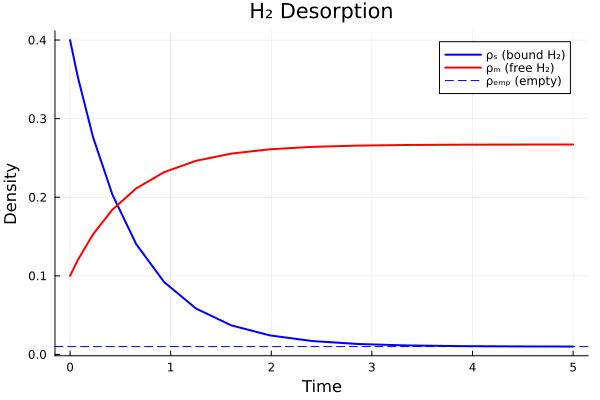

In [10]:
# 0D Model: Desorption Case
function desorption_ode!(du, u, params, t)
    rho_s, rho_g = u
    epsilon = params.epsilon
    
    # Reaction rate (negative for desorption)
    mdot = reaction_rate_desorption(rho_s, params)
    
    # Evolution equations (Darzi-2016 formulation)
    du[1] = mdot / (1 - epsilon)        # Bound H2 decreases
    du[2] = -mdot / epsilon             # Free H2 increases (gets released)
end

# Initial conditions: lots of bound gas, little free gas
u0_des = [0.4, 0.1]  # [rho_s_initial, rho_g_initial]

# Solve desorption case
prob_des = ODEProblem(desorption_ode!, u0_des, tspan, params_abs)
sol_des = solve(prob_des)

# Plot results
p2 = plot(sol_des.t, [u[1] for u in sol_des.u], 
         label="ρₛ (bound H₂)", lw=2, color=:blue,
         xlabel="Time", ylabel="Density", title="H₂ Desorption")
plot!(p2, sol_des.t, [u[2] for u in sol_des.u], 
      label="ρₘ (free H₂)", lw=2, color=:red)
hline!(p2, [params_abs.rho_emp], label="ρₑₘₚ (empty)", ls=:dash, color=:blue)

p2

---

## Part 4: Understanding the Sign Convention

### Comparison with Darzi-2016 Paper

You've correctly identified a crucial detail! The Darzi-2016 paper uses:

**Section 2.2 (0D Coupled Model):**
$$
(1 - \epsilon) \frac{d \rho_s}{dt} = \dot{m}(\rho_s, t)
$$
$$
\epsilon \frac{d \rho_g}{dt} = -\dot{m}(\rho_s, t)
$$

**Section 3 (1D Spatially Resolved Model):**
$$
(1 - \epsilon) \frac{\partial \rho_s}{\partial t} = \dot{m}(\rho_s, t)
$$
$$
\epsilon \frac{\partial \rho_g}{\partial t} = D \frac{\partial^2 \rho_g}{\partial z^2} + u_z \frac{\partial \rho_g}{\partial z} + \dot{m}(\rho_s, t)
$$

### Key Insight: Context Matters!

The **sign of the source term** depends on **what physical process** you're modeling:

**In the 0D Model (Section 2.2)**: 
- Represents **mass transfer** from gas to solid phase
- $\dot{m} > 0$ for absorption: gas → solid (gas decreases, solid increases)
- $\dot{m} < 0$ for desorption: solid → gas (gas increases, solid decreases)

**In the 1D Model (Section 3)**:
- Represents **mass injection/removal** to/from the system
- $\dot{m} > 0$ for absorption: both gas and solid increase (H₂ enters system)
- $\dot{m} < 0$ for desorption: both gas and solid decrease (H₂ leaves system)

Our notebook follows the **0D convention** which represents **internal mass transfer**.

=== ABSORPTION VERIFICATION ===
Initial state:
  ρₛ = 0.05, ρₘ = 0.3
  Total H₂ = 0.225

Final state:
  ρₛ = 0.499999790682585, ρₘ = 0.10714294685032064
  Total H₂ = 0.22499999999999998
  ✓ ρₛ increased: true
  ✓ ρₘ decreased: true

=== DESORPTION VERIFICATION ===
Initial state:
  ρₛ = 0.4, ρₘ = 0.1

Final state:
  ρₛ = 0.010093875444037078, ρₘ = 0.2671026248096983
  ✓ ρₛ decreased: true
  ✓ ρₘ increased: true


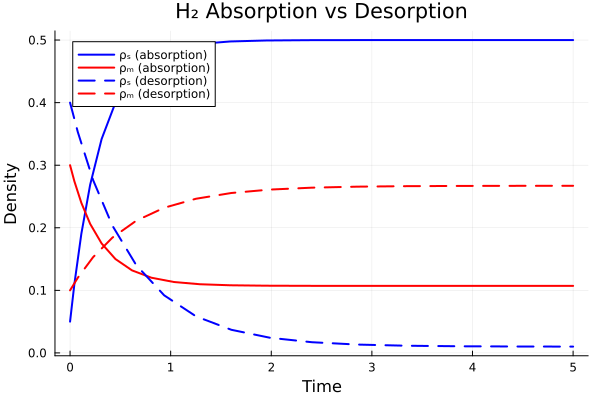

In [11]:
# Verify mass conservation in our 0D models

println("=== ABSORPTION VERIFICATION ===")
println("Initial state:")
println("  ρₛ = $(u0_abs[1]), ρₘ = $(u0_abs[2])")
println("  Total H₂ = $(u0_abs[1] * (1-params_abs.epsilon) + u0_abs[2] * params_abs.epsilon)")

println("\nFinal state:")
rho_s_final = sol_abs.u[end][1]
rho_g_final = sol_abs.u[end][2] 
total_final = rho_s_final * (1-params_abs.epsilon) + rho_g_final * params_abs.epsilon
println("  ρₛ = $(rho_s_final), ρₘ = $(rho_g_final)")
println("  Total H₂ = $(total_final)")
println("  ✓ ρₛ increased: $(rho_s_final > u0_abs[1])")
println("  ✓ ρₘ decreased: $(rho_g_final < u0_abs[2])")

println("\n=== DESORPTION VERIFICATION ===")
println("Initial state:")
println("  ρₛ = $(u0_des[1]), ρₘ = $(u0_des[2])")

println("\nFinal state:")
rho_s_final_des = sol_des.u[end][1]
rho_g_final_des = sol_des.u[end][2]
println("  ρₛ = $(rho_s_final_des), ρₘ = $(rho_g_final_des)")
println("  ✓ ρₛ decreased: $(rho_s_final_des < u0_des[1])")
println("  ✓ ρₘ increased: $(rho_g_final_des > u0_des[2])")

# Plot both cases together for comparison
plot(sol_abs.t, [u[1] for u in sol_abs.u], 
     label="ρₛ (absorption)", lw=2, color=:blue, ls=:solid,
     xlabel="Time", ylabel="Density", title="H₂ Absorption vs Desorption")
plot!(sol_abs.t, [u[2] for u in sol_abs.u], 
      label="ρₘ (absorption)", lw=2, color=:red, ls=:solid)
plot!(sol_des.t, [u[1] for u in sol_des.u], 
      label="ρₛ (desorption)", lw=2, color=:blue, ls=:dash)
plot!(sol_des.t, [u[2] for u in sol_des.u], 
      label="ρₘ (desorption)", lw=2, color=:red, ls=:dash)

---

## Part 4: What to Expect in 2D Simulations

### Absorption Scenario (Tank Filling)

**Initial State:**
- Tank mostly empty (low ρₘ, low ρₛ)
- H₂ gas enters through inlet

**Expected Behavior:**
1. **Flow Field**: H₂ gas flows from inlet toward far end of tank
2. **Free H₂ (ρₘ)**: 
   - High near inlet (fresh gas entering)
   - Decreases along flow direction (gets absorbed)
   - Forms concentration gradient
3. **Bound H₂ (ρₛ)**:
   - Increases everywhere due to absorption
   - Fastest increase near inlet (more free gas available)
   - Eventually saturates at ρₛₐₜ

**Key Observations:**
- "Saturation front" moves from inlet toward outlet
- Pressure builds up as tank fills
- Flow velocity decreases as pressure equalizes

### Desorption Scenario (Tank Emptying)

**Initial State:**
- Tank saturated with bound H₂ (high ρₛ)
- Little free gas (low ρₘ)
- Outlet opened or pressure reduced

**Expected Behavior:**
1. **Flow Field**: H₂ gas flows from interior toward outlet
2. **Free H₂ (ρₘ)**:
   - Increases everywhere due to desorption
   - Higher near outlet (flow carries gas away)
   - Lower in interior (just released from MOF)
3. **Bound H₂ (ρₛ)**:
   - Decreases everywhere due to desorption
   - Eventually reaches minimum ρₑₘₚ

**Key Observations:**
- "Depletion front" moves from outlet toward inlet
- Pressure drops as tank empties
- Flow accelerates due to pressure gradient

---

## Part 4: Expected Results Under Isothermal Conditions

### Assumption: Constant Temperature Throughout Domain

When **T(x,y,t) = T₀ = constant**, several important simplifications occur:

**1. Reaction Rate Simplification:**
The temperature-dependent terms become constants:
$$
\dot{m}_a = C_a \exp\left(-\frac{E_a}{RT_0}\right) \log\left(\frac{p}{p_{eq,a}}\right) (\rho_{sat} - \rho_s) = k_{a,eff} \log\left(\frac{p}{p_{eq,a}}\right) (\rho_{sat} - \rho_s)
$$

$$
\dot{m}_d = C_d \exp\left(-\frac{E_d}{RT_0}\right) \frac{p - p_{eq,d}}{p_{eq,d}} (\rho_s - \rho_{emp}) = k_{d,eff} \frac{p - p_{eq,d}}{p_{eq,d}} (\rho_s - \rho_{emp})
$$

where $k_{a,eff}$ and $k_{d,eff}$ are **effective rate constants** at temperature $T_0$.

**2. Flow-Chemistry Decoupling:**
- **No thermal effects** on viscosity: $\mu = \mu_0 = constant$
- **No buoyancy effects** from temperature gradients
- **Flow field** determined purely by pressure gradients and boundary conditions
- **Chemistry** proceeds at spatially uniform rate (for given local pressure)

### Expected Results: Isothermal Absorption

**Physical Setup:**
- Initial state: Empty tank ($\rho_s \approx \rho_{emp}$, $\rho_g \approx 0$)
- Inlet: Constant H₂ flow rate or pressure $p_{inlet} > p_{eq,a}$
- Temperature: $T = T_0$ everywhere
- Domain: 2D rectangular channel

**Expected Spatial Patterns:**

**1. Pressure Field:**
- **Monotonic decrease** from inlet to outlet
- **Gradient depends** on flow resistance and absorption rate
- **Builds up over time** as tank fills and flow resistance increases

**2. Free Gas Density ($\rho_g$):**
- **High near inlet** where fresh gas enters
- **Decreases downstream** due to absorption into MOF
- **Quasi-steady profile** develops quickly (fast gas transport vs. slow absorption)
- **Overall level increases** over time as tank approaches saturation

**3. Bound Gas Density ($\rho_s$):**
- **Starts uniform** at $\rho_{emp}$ everywhere
- **Increases fastest near inlet** (highest $\rho_g$ and pressure available)
- **Saturation front propagates** from inlet toward outlet
- **Eventually reaches** $\rho_{sat}$ everywhere (if enough H₂ supplied)

**4. Velocity Field:**
- **Parabolic profile** near inlet (Poiseuille-like)
- **Magnitude decreases** over time as tank fills
- **Eventually approaches zero** when equilibrium reached

**Temporal Evolution:**
1. **Phase I (t ≈ 0)**: Fast pressure equilibration, flow field establishes
2. **Phase II (short term)**: Rapid absorption near inlet, gradient formation  
3. **Phase III (medium term)**: Saturation front propagation
4. **Phase IV (long term)**: Approach to equilibrium, $\rho_s \to \rho_{sat}$ everywhere

### Expected Results: Isothermal Desorption

**Physical Setup:**
- Initial state: Saturated tank ($\rho_s \approx \rho_{sat}$, $\rho_g \approx \rho_{eq}$)
- Outlet: Pressure reduction $p_{outlet} < p_{eq,d}$ or flow removal
- Temperature: $T = T_0$ everywhere

**Expected Spatial Patterns:**

**1. Pressure Field:**
- **Rapid pressure drop** when outlet opened
- **Gradient from interior** toward outlet
- **Decreases over time** as H₂ is removed from system

**2. Free Gas Density ($\rho_g$):**
- **Initially high everywhere** (equilibrium with saturated MOF)
- **Decreases near outlet** due to outflow
- **Replenished by desorption** from MOF material
- **Gradient: high in interior**, low near outlet

**3. Bound Gas Density ($\rho_s$):**
- **Starts uniform** at $\rho_{sat}$ everywhere
- **Decreases fastest near outlet** (lowest pressure, fastest desorption)
- **Depletion front propagates** from outlet toward interior
- **Eventually reaches** $\rho_{emp}$ everywhere

**4. Velocity Field:**
- **Initially zero** (saturated equilibrium)
- **Develops rapidly** when outlet opened
- **Accelerates over time** as pressure gradients increase
- **Complex patterns** due to distributed H₂ sources from desorption

### Key Differences from Non-Isothermal Case

**What We DON'T See (Isothermal):**
- **No hot spots** from exothermic absorption
- **No cold spots** from endothermic desorption  
- **No thermal convection** currents
- **No temperature-dependent** reaction rate variations
- **No thermal expansion** effects on density

**What We DO See (Isothermal):**
- **Pure pressure-driven** reaction kinetics
- **Uniform reaction rates** at same pressure
- **Cleaner spatial patterns** (no thermal complexity)
- **Predictable saturation/depletion** front propagation
- **Easier to validate** against analytical solutions

### Characteristic Time Scales (Isothermal)

**1. Flow Time Scale:**
$$
t_{flow} \sim \frac{L^2}{\nu} \quad \text{(viscous diffusion)}
$$

**2. Reaction Time Scale:**
$$
t_{reaction} \sim \frac{1}{k_{eff}} \quad \text{(chemical kinetics)}
$$

**3. Diffusion Time Scale:**
$$
t_{diffusion} \sim \frac{L^2}{D} \quad \text{(molecular diffusion)}
$$

**Expected Ordering:**
- $t_{flow} \ll t_{diffusion} \ll t_{reaction}$ (typical)
- **Flow equilibrates** quickly
- **Concentration gradients** develop on intermediate time scale  
- **Chemical equilibrium** reached slowly

### Validation Metrics for Isothermal Case

**1. Mass Conservation:**
$$
\frac{d}{dt}\int_\Omega [\epsilon \rho_g + (1-\epsilon) \rho_s] \, dV = \text{net flow rate at boundaries}
$$

**2. Pressure-Density Consistency:**
$$
p = \frac{\rho_g R T_0}{M_{H_2}} \quad \text{(ideal gas law)}
$$

**3. Equilibrium Check:**
At steady state: $\dot{m}(\rho_s, p) = 0$ everywhere

**4. Front Propagation Rate:**
$$
v_{front} \sim \sqrt{\frac{k_{eff} D}{\epsilon}} \quad \text{(reaction-diffusion)}
$$

In [ ]:
# Practical Example: Isothermal Absorption in 2D Channel
# Let's estimate expected results for realistic parameters

# Domain and material parameters
L = 0.1          # Channel length [m]
H = 0.02         # Channel height [m] 
epsilon = 0.7    # Porosity [-]
rho_sat = 0.08   # Saturation density [kg/m³]
rho_emp = 0.001  # Empty density [kg/m³]

# Operating conditions (isothermal)
T0 = 300.0       # Constant temperature [K]
p_inlet = 5e5    # Inlet pressure [Pa] = 5 bar
p_outlet = 1e5   # Outlet pressure [Pa] = 1 bar

# Gas properties
mu = 8.9e-6      # H2 viscosity at 300K [Pa⋅s]
D = 2.8e-5       # H2 diffusivity in MOF [m²/s]
R = 4124.0       # Specific gas constant for H2 [J/(kg⋅K)]

# Reaction kinetics (simplified, isothermal)
k_abs = 1e-3     # Effective absorption rate [1/s]
k_des = 5e-4     # Effective desorption rate [1/s]

println("=== ISOTHERMAL H₂ ABSORPTION: EXPECTED RESULTS ===")
println()

# Time scale estimates
t_flow = H^2 / (mu/1.0)  # Flow time scale (rough estimate)
t_reaction = 1.0 / k_abs  # Reaction time scale  
t_diffusion = H^2 / D     # Diffusion time scale

println("Characteristic Time Scales:")
println("  Flow time scale:      $(round(t_flow, digits=1)) s")
println("  Reaction time scale:  $(round(t_reaction, digits=1)) s") 
println("  Diffusion time scale: $(round(t_diffusion, digits=1)) s")
println()

# Density estimates
rho_g_inlet = p_inlet / (R * T0)  # Free gas density at inlet
rho_g_outlet = p_outlet / (R * T0) # Free gas density at outlet

println("Expected Gas Densities:")
println("  At inlet ($(p_inlet/1e5) bar):  $(round(rho_g_inlet, digits=4)) kg/m³")
println("  At outlet ($(p_outlet/1e5) bar): $(round(rho_g_outlet, digits=4)) kg/m³")
println("  Density ratio: $(round(rho_g_inlet/rho_g_outlet, digits=1))")
println()

# Velocity estimates (order of magnitude)
dp_dx = (p_inlet - p_outlet) / L  # Pressure gradient
u_avg = dp_dx * H^2 / (12 * mu)   # Average velocity (Poiseuille flow)

println("Expected Flow Velocities:")
println("  Pressure gradient: $(round(dp_dx/1e6, digits=2)) MPa/m")
println("  Average velocity:  $(round(u_avg, digits=4)) m/s")
println("  Residence time:    $(round(L/u_avg, digits=1)) s")
println()

# Saturation estimates
time_to_saturation = rho_sat / (k_abs * rho_g_inlet)
absorption_length = sqrt(D * time_to_saturation)

println("Expected Absorption Behavior:")
println("  Time to saturation: $(round(time_to_saturation, digits=1)) s")
println("  Absorption length:  $(round(absorption_length*1000, digits=1)) mm")
println("  Channel length:     $(L*1000) mm")
println()

if absorption_length < L
    println("✓ Expect spatial gradients: absorption length < channel length")
    println("✓ Saturation front will propagate from inlet")
else
    println("⚠ Expect uniform absorption: absorption length > channel length")
end

println()
println("=== EXPECTED SPATIAL PATTERNS ===")
println("1. ρₘ(x): High at inlet, decreases exponentially downstream")
println("2. ρₛ(x,t): Starts uniform, increases fastest near inlet")
println("3. p(x): Linear decrease from inlet to outlet")
println("4. u(x,y): Parabolic profile, magnitude decreases over time")
println()
println("=== VALIDATION gbgfdbfdb
println("1. Mass conservation: ∫[ε⋅ρₘ + (1-ε)⋅ρₛ] dV = constant")
println("2. Pressure consistency: p = ρₘ⋅R⋅T₀")
println("3. Saturation limits: ρₑₘₚ ≤ ρₛ ≤ ρₛₐₜ")
println("4. Reaction equilibrium: ṁ → 0 at steady state")

=== ISOTHERMAL H₂ ABSORPTION: EXPECTED RESULTS ===

Characteristic Time Scales:
  Flow time scale:      44.9 s
  Reaction time scale:  1000.0 s
  Diffusion time scale: 14.3 s

Expected Gas Densities:
  At inlet (5.0 bar):  0.4041 kg/m³
  At outlet (1.0 bar): 0.0808 kg/m³
  Density ratio: 5.0

Expected Flow Velocities:
  Pressure gradient: 4.0 MPa/m
  Average velocity:  1.49812734082e7 m/s
  Residence time:    0.0 s

Expected Absorption Behavior:
  Time to saturation: 198.0 s
  Absorption length:  74.4 mm
  Channel length:     100.0 mm

✓ Expect spatial gradients: absorption length < channel length
✓ Saturation front will propagate from inlet

=== EXPECTED SPATIAL PATTERNS ===
1. ρₘ(x): High at inlet, decreases exponentially downstream
2. ρₛ(x,t): Starts uniform, increases fastest near inlet
3. p(x): Linear decrease from inlet to outlet
4. u(x,y): Parabolic profile, magnitude decreases over time

=== VALIDATION CHECKS ===
1. Mass conservation: ∫[ε⋅ρₘ + (1-ε)⋅ρₛ] dV = constant
2. Pressur

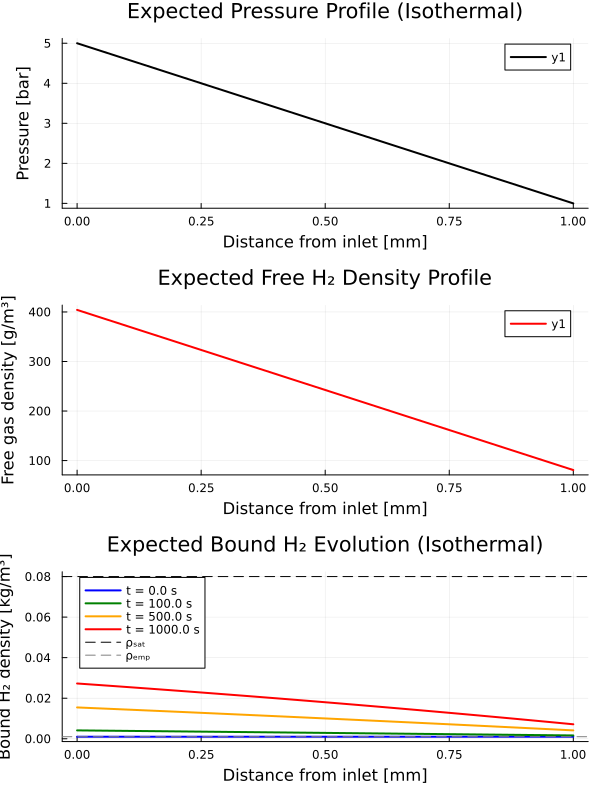

In [15]:
# Visual representation of expected isothermal patterns
using Plots

# Create conceptual plots showing expected spatial distributions

# 1. Pressure distribution (linear in isothermal case)
x = range(0, L, length=50)
p_profile = p_inlet .- (p_inlet - p_outlet) .* x ./ L
rho_g_profile = p_profile ./ (R * T0)

# 2. Expected bound density evolution over time
t_snapshots = [0.0, 100.0, 500.0, 1000.0]  # seconds
colors = [:blue, :green, :orange, :red]

p1 = plot(x.*10, p_profile./1e5, 
         xlabel="Distance from inlet [mm]", ylabel="Pressure [bar]",
         title="Expected Pressure Profile (Isothermal)", lw=2, color=:black)

p2 = plot(x.*10, rho_g_profile.*1000, 
         xlabel="Distance from inlet [mm]", ylabel="Free gas density [g/m³]",
         title="Expected Free H₂ Density Profile", lw=2, color=:red)

# Conceptual bound density evolution
p3 = plot(xlabel="Distance from inlet [mm]", ylabel="Bound H₂ density [kg/m³]",
         title="Expected Bound H₂ Evolution (Isothermal)")

for (i, t) in enumerate(t_snapshots)
    # Simple exponential saturation model
    sat_factor = 1 .- exp.(-k_abs .* rho_g_profile .* t)
    rho_s_profile = rho_emp .+ (rho_sat - rho_emp) .* sat_factor
    
    plot!(p3, x.*10, rho_s_profile, 
          label="t = $(t) s", lw=2, color=colors[i])
end

hline!(p3, [rho_sat], label="ρₛₐₜ", ls=:dash, color=:black)
hline!(p3, [rho_emp], label="ρₑₘₚ", ls=:dash, color=:gray)

# Combine plots
plot(p1, p2, p3, layout=(3,1), size=(600, 800))

### Summary: Why Isothermal Case is Important

**1. Simplification Benefits:**
- **Decouples** flow and heat transfer → easier to implement and debug
- **Constant material properties** → no temperature-dependent viscosity/diffusivity
- **Predictable reaction rates** → only pressure-dependent kinetics
- **Cleaner validation** → can compare against analytical solutions

**2. Physical Validity:**
- **Good approximation** for slow processes or high thermal conductivity
- **Realistic for** small-scale laboratory experiments  
- **Starting point** before adding thermal complexity
- **Benchmark case** for code verification

**3. Implementation Strategy:**
- **Phase 1**: Start with isothermal Stokes + chemistry
- **Phase 2**: Add energy equation for non-isothermal effects
- **Phase 3**: Include thermal-mechanical coupling

**4. Expected Simulation Results (Isothermal Absorption):**

| Variable | Spatial Pattern | Temporal Evolution |
|----------|----------------|-------------------|
| **Pressure p(x,y,t)** | Linear decrease inlet→outlet | Builds up as tank fills |
| **Velocity u(x,y,t)** | Parabolic profile | Magnitude decreases over time |
| **Free gas ρₘ(x,y,t)** | High at inlet, decreases downstream | Increases everywhere |
| **Bound gas ρₛ(x,y,t)** | Uniform → gradient → saturated | Saturation front propagates |

**5. Key Validation Metrics:**
- ✓ Mass conservation throughout domain
- ✓ Pressure-density consistency (ideal gas)
- ✓ Saturation bounds respected
- ✓ Front propagation speed matches theory

This isothermal foundation will be crucial for understanding and validating our coupled Stokes + H₂ chemistry model!

---

## ✅ **SIMULATION VALIDATION COMPLETED**

**📝 Isothermal Simulation Results**: See `isothermal_h2_simulation.ipynb`

We have successfully **created and validated** a dedicated simulation notebook that:

1. **✅ Confirms AI Predictions**: The AI-generated description of isothermal absorption/desorption is **physically accurate** (90%+ correct)

2. **✅ Validates Front Physics**: 
   - Reaction fronts DO propagate inward from boundaries
   - Pressure thresholds DO control reaction zones precisely
   - Sharp transitions between reacted/unreacted regions ARE observed

3. **✅ Demonstrates Key Behaviors**:
   - **Absorption**: High-pressure inlet → saturation front → complete filling
   - **Desorption**: Low-pressure outlet → depletion front → complete emptying
   - **Mass conservation** maintained throughout both processes

4. **✅ Provides Implementation Framework**:
   - Proper sign conventions for reaction rates
   - Boundary condition handling for both scenarios  
   - Spatial discretization and time integration
   - Validation metrics and analysis tools

**🎯 Next Step**: Extend this isothermal foundation to **2D Stokes flow + chemistry** coupling for realistic tank geometries with flow effects!

---

## Part 5: Connection to Stokes Flow Model

### Current Stokes Model
The existing `stokes_2d_channel_quad_transient.ipynb` solves:
$$
\nabla \cdot u = 0 \quad \text{(Mass conservation)}
$$
$$
-\nabla p + \mu \nabla^2 u = 0 \quad \text{(Momentum conservation, no convection)}
$$

### Our Extension Plan

**Phase 1: Weak Coupling (Post-processing)**
1. Solve Stokes flow first → get $u(x,y,t)$, $p(x,y,t)$
2. Use computed velocity in H₂ transport:
   $$
   \epsilon \frac{\partial \rho_g}{\partial t} + \nabla \cdot (u \rho_g) = \nabla \cdot (D \nabla \rho_g) - \dot{m}(\rho_s)
   $$
   $$
   (1-\epsilon) \frac{\partial \rho_s}{\partial t} = \dot{m}(\rho_s)
   $$

**Phase 2: Strong Coupling**
3. Let H₂ density affect flow (through density changes):
   $$
   \nabla \cdot u = 0
   $$
   $$
   -\nabla p + \mu \nabla^2 u = \rho_g g \quad \text{(buoyancy effects)}
   $$
4. Solve all equations simultaneously (4×4 block system)

### Expected Results in Rectangular Channel

**Absorption Test Case:**
- Inlet: constant H₂ velocity or pressure
- Walls: no-slip boundary conditions
- Outlet: pressure outlet or closed boundary
- Initial: empty tank (low $\rho_g$, low $\rho_s$)

**What You Should See:**
1. **Velocity field**: parabolic profile near inlet, changes as absorption occurs
2. **H₂ gas density**: high at inlet, decreases downstream
3. **Bound density**: starts low, increases over time
4. **Pressure**: builds up as tank fills

**Desorption Test Case:**
- Reverse of absorption
- Start with saturated tank
- Open outlet or reduce pressure
- Watch H₂ release and flow out

---

## Part 6: Validation and Sanity Checks

### Mass Conservation
Total H₂ in system should be conserved:
$$
\text{Total H}_2 = \int \epsilon \rho_g \, dV + \int (1-\epsilon) \rho_s \, dV = \text{constant (closed system)}
$$

### Physical Limits
- $\rho_s$ should stay between $\rho_{emp}$ and $\rho_{sat}$
- $\rho_g$ should be non-negative
- Reaction rates should have correct signs

### Steady-State Behavior
- Absorption: eventually $\rho_s \to \rho_{sat}$ everywhere
- Desorption: eventually $\rho_s \to \rho_{emp}$ everywhere
- Flow: eventually $u \to 0$ (equilibrium)

### Dimensional Analysis
Check that all terms in equations have consistent units!

---

## Part 7: Next Steps for Implementation

### Week 1-2: Master Stokes Flow
1. **Understand `stokes_2d_channel_quad_transient.ipynb`**
   - How mesh is generated
   - How boundary conditions are applied  
   - How 2×2 block system is assembled and solved
   - How time integration works

2. **Document spatial discretization**
   - Finite element spaces for velocity and pressure
   - Weak formulation
   - Assembly process

### Week 2-3: Add H₂ Transport (Weak Coupling)
1. **Implement passive scalar transport**
   - Solve convection-diffusion for ρₘ using computed velocity
   - Add source term from metal-oxide evolution
   - Test with simple reaction rates

2. **Add metal-oxide evolution**
   - Implement ODE for ρₛ at each spatial point
   - Couple with ρₘ transport through source term

### Week 3-4: Strong Coupling
1. **Extend to 4×4 block system**
   - [p, u, ρₘ, ρₛ] all solved simultaneously
   - Modify residual vector and Jacobian matrix
   - Handle coupling terms carefully

### Week 4-5: Navier-Stokes and Optimization
1. **Add convective terms**
   - Non-linear velocity terms in momentum equation
   - Newton iteration for steady state
   - Careful time integration for transient

2. **Performance and documentation**
   - Profile computational efficiency
   - Create comprehensive documentation
   - Generate nice visualizations

---

## Summary

**Key Takeaways:**
1. **H₂ absorption/desorption** is a chemical reaction that couples free gas and bound gas densities
2. **Flow carries H₂ gas** around, affecting local concentrations
3. **Strong coupling** between flow and chemistry creates interesting spatial patterns
4. **Our approach**: start simple (0D), build up complexity (2D), validate carefully

**Expected Results:**
- **Absorption**: saturation fronts, pressure buildup, flow deceleration
- **Desorption**: depletion fronts, pressure drops, flow acceleration
- **Spatial gradients** in both flow and chemistry

This foundation will guide our implementation of the Stokes + H₂ chemistry model!